In [461]:
# import basic libraries
import pickle
import yt
import numpy as np
import matplotlib.pyplot as plt
from math import log, log10, pi
from astropy import units as u
from yt.utilities.cosmology import Cosmology

# import halo catalogue func
from yt.analysis_modules.halo_analysis.api import *

In [12]:
# import libraries - not sure what they do
# used to ensure halo catalog loads properly
import tempfile
import shutil
import os

# Create temporary directory for storing files
tmpdir = tempfile.mkdtemp()

In [281]:
# load halo dataset
halos_ds = yt.load('./LG4_2048_40pc/rd0110/halo_catalogs/catalog/catalog.0.h5')

# load raw dataset
ds = yt.load('~/../../tigress/cen/LG4_2048_40pc/RD0070/redshift0070')

# Instantiate a catalog using those two paramter files
hc = HaloCatalog(halos_ds=halos_ds, output_dir=os.path.join(tmpdir, 'halo_catalog'))
hc.load()

yt : [INFO     ] 2017-07-28 10:43:25,964 Parameters: current_time              = 6.86908772332e+16
yt : [INFO     ] 2017-07-28 10:43:25,966 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2017-07-28 10:43:25,970 Parameters: domain_left_edge          = [ 0.  0.  0.]
yt : [INFO     ] 2017-07-28 10:43:25,973 Parameters: domain_right_edge         = [  3.33803289e+25   3.33803289e+25   3.33803289e+25]
yt : [INFO     ] 2017-07-28 10:43:25,977 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2017-07-28 10:43:25,979 Parameters: current_redshift          = 2.9999999666
yt : [INFO     ] 2017-07-28 10:43:25,981 Parameters: omega_lambda              = 0.712
yt : [INFO     ] 2017-07-28 10:43:25,983 Parameters: omega_matter              = 0.288
yt : [INFO     ] 2017-07-28 10:43:25,985 Parameters: hubble_constant           = 0.6933
yt : [INFO     ] 2017-07-28 10:43:26,042 Parameters: current_time              = 158.01757996843
yt : [INFO     ] 2017-07-28 10:43:26,044 Parame

In [559]:
redshift_filename = './LG4_2048_40pc/rd0070/redshift0070'

# load redshift and Omega values from parameter file
with open(redshift_filename, 'rt') as param_file:
    param_contents = param_file.read()
    
    #redshift
    cindex1 = param_contents.find('CosmologyCurrentRedshift')
    cindex_eq = param_contents.find('=', cindex1)
    cindex2 = param_contents.find('\n', cindex_eq, cindex_eq + 100)
    redshift = float(param_contents[cindex_eq+2:cindex2])
    
    # omega_m
    cindex1 = param_contents.find('CosmologyOmegaMatterNow')
    cindex_eq = param_contents.find('=', cindex1)
    cindex2 = param_contents.find('\n', cindex_eq, cindex_eq + 100)
    omega_m = float(param_contents[cindex_eq+2:cindex2])
    
    # hubble const now
    cindex1 = param_contents.find('CosmologyHubbleConstantNow')
    cindex_eq = param_contents.find('=', cindex1)
    cindex2 = param_contents.find('\n', cindex_eq, cindex_eq + 100)
    hubb_now = float(param_contents[cindex_eq+2:cindex2]) *(u.km / u.s / u.Mpc) 
    
    # cosmological constant
    cindex1 = param_contents.find('CosmologyOmegaLambdaNow')
    cindex_eq = param_contents.find('=', cindex1)
    cindex2 = param_contents.find('\n', cindex_eq, cindex_eq + 100)
    cos_const = float(param_contents[cindex_eq+2:cindex2])
    
    # omega baryon as specified by Renyue
    omega_b = 0.048
    
    # box size
    cindex1 = param_contents.find('CosmologyComovingBoxSize')
    cindex_eq = param_contents.find('=', cindex1)
    cindex2 = param_contents.find('\n', cindex_eq, cindex_eq + 100)
    box_size = float(param_contents[cindex_eq+2:cindex2]) * u.Mpc
    
    # left edge strings
    cindex1 = param_contents.find('RefineRegionLeftEdge')
    cindex_eq = param_contents.find('=', cindex1)
    cindex2 = param_contents.find('\n', cindex_eq, cindex_eq + 100)
    left_edge_string = param_contents[cindex_eq+2:cindex2]
    left_edges = left_edge_string.split()
    
    # right edge strings
    cindex1 = param_contents.find('RefineRegionRightEdge')
    cindex_eq = param_contents.find('=', cindex1)
    cindex2 = param_contents.find('\n', cindex_eq, cindex_eq + 100)
    right_edge_string = param_contents[cindex_eq+2:cindex2]
    right_edges = right_edge_string.split()
    
# calculate hubble const for simulation
hubb_z = (100* hubb_now.to('s**-1')) * ((omega_m * (1 + redshift)**3) + (1 - omega_m))**0.5

# calculate crit density and threshold
GRAV_CONST = (6.67408e-11 * u.m**3 /(u.kg * u.s**2)).to('cm^3*g^-1*s^-2')
crit_dens = (3 * hubb_z**2) / (8 * pi * GRAV_CONST)
omegas = (1 - (omega_b / omega_m))
threshold = 200 * omegas * crit_dens

# calculate current time
co = Cosmology(hubb_now.value, omega_m, cos_const)
time_now = co.hubble_time(redshift) * u.s

# min and max bounds for radial profile
# min = 1 kpc proper
# max = 0.5 Mpc comoving
# convert to centimeters value (without astropy units)
rad_min = 1 * u.kpc
rad_max = 0.5 * u.Mpc
rad_max = rad_max / (1 + redshift) # convert to physical

# specify boundaries of zoom-in box
# scaling factor multiplied by info from text file 
# units in cm
scaling =  ((box_size / hubb_now.value) / (1 + redshift)).to('kpc') # size of box
xmin = scaling*float(left_edges[0])
ymin = scaling*float(left_edges[1])
zmin = scaling*float(left_edges[2])
xmax = scaling*float(right_edges[0])
ymax = scaling*float(right_edges[1])
zmax = scaling*float(right_edges[2])

In [794]:
# --load ratio of stellar mass to halo mass
# first list uses first output of TotalMass funct
# second list uses second output

with open('./LG4_2048_40pc/rd0070/ratio_list0070_1.txt', 'rb') as ratiofile1:
    ratiolist1 = pickle.load(ratiofile1)
    
with open('./LG4_2048_40pc/rd0070/ratio_list0070_2.txt', 'rb') as ratiofile2:
    ratiolist2 = pickle.load(ratiofile2)
    
# load master calc lists
with open('./master_calc0030', 'rb') as infile:
    halo_list0030 = pickle.load(infile)
with open('./master_calc0050', 'rb') as infile:
    halo_list0050 = pickle.load(infile)
with open('./master_calc0070', 'rb') as infile:
    halo_list0070 = pickle.load(infile)
with open('./master_calc0090', 'rb') as infile:
    halo_list0090 = pickle.load(infile)
with open('./master_calc0110', 'rb') as infile:
    halo_list0110 = pickle.load(infile)

In [740]:
halo_list0030

[[2,
  6174,
  <Quantity 2627.5477718091106 kpc>,
  <Quantity 2544.1446953630893 kpc>,
  <Quantity 2566.9740712620464 kpc>,
  <Quantity 9060402645.837389 solMass>,
  <Quantity 8196059175.637566 solMass>,
  <Quantity 8.179926407820114 kpc>,
  <Quantity 12.047283394153846 kpc>,
  -1,
  <Quantity 1087224856.5641356 solMass>,
  <Quantity 179782332.00519875 solMass>,
  <Quantity 5095953707694528.0 s>,
  0.9926139823748812,
  <Quantity 0.6091408165211215 kpc>,
  <Quantity 5.409627718652216e+25 1 / s>],
 [4,
  6173,
  <Quantity 2486.6782986976655 kpc>,
  <Quantity 2492.584062611104 kpc>,
  <Quantity 2981.286788305112 kpc>,
  <Quantity 7849008048.218473 solMass>,
  <Quantity 6300394697.621254 solMass>,
  <Quantity 7.797795148079457 kpc>,
  <Quantity 13.030727461646416 kpc>,
  -1,
  <Quantity 1133655153.3998017 solMass>,
  <Quantity 210727364.1386518 solMass>,
  <Quantity 5753502563457781.0 s>,
  4.089688143275694,
  <Quantity 2.0409231219985373 kpc>,
  <Quantity 8.08990167090576e+25 1 / s>],
 

In [709]:
min_mass = 1e10 * u.Msun
mindex = 0

toSkip = (697, 825, 902, 914, 1111, 1211, 556)

count_agezero = 0
count_stelzero = 0
for halo in halo_list:
    mass = halo[5]
    rad = halo[7]
    stellar_mass = halo[11]
    ave_age = halo[12]
    
    if ave_age ==0:
        count_agezero +=1
    if stellar_mass == 0:
        count_stelzero +=1
    

count_agezero, count_stelzero, len(halo_list)

(6156, 6156, 8233)

In [683]:
lists0090

NameError: name 'lists0090' is not defined

In [924]:
toCreate = "rd0030"

In [925]:
# pick halo list depending on toCreate
if toCreate == "rd0030":
    halo_list = halo_list0030
    print("picked 0030")
if toCreate == "rd0050":
    halo_list = halo_list0050
    print("picked 0050")
if toCreate == "rd0070":
    halo_list = halo_list0070
    print("picked 0070")
if toCreate == "rd0090":
    halo_list = halo_list0090
    print("picked 0090")
if toCreate == "rd0110":
    halo_list = halo_list0110
    print("picked 0110")
    
# create new ratio lists
# < 3e7 Msun, < 3e8 Msun, > 3e8 Msun
# masks used to limit Msun to 3e7-3e8, 3e8-3e9
gasratiolists = [[], [], [], []]
stelratiolists = [[], [], [], []]
agelists = [[], [], [], []]
proxlists = [[], [], [], []]
radratiolists = [[], [], [], []]
peaklists = [[], [], [], []]
formlists = [[], [], [], []]
masslists = [[], [], [], []]
stelmasslists = [[], [], [], []]

for halo in halo_list:
    # find parameters of halo
    x = halo[2]
    y = halo[3]
    z = halo[4]
    center = [(x/scaling).value, (y/scaling).value, (z/scaling).value]
    halo_mass = halo[5] # new mass
    radius = halo[7] # new radius
    isSatellite = halo[9]
    gas_mass = halo[10]
    stellar_mass = halo[11]
    ave_age = halo[12]
    prox = halo[13]
    stel_rad = halo[14]
    formrate = halo[15]
    
    print(formrate)
#     print(halo_mass, stellar_mass2, ave_age)

    # check that not a satellite 
    if isSatellite >= 0:
        print('IsSat')
        continue
    
    # create bools for simplification
    isAgeZero = (ave_age == 0)
    isStelMassZero = (stellar_mass == 0)
    
    # find the ratios
    if not isStelMassZero:
        ratio1 = gas_mass.to('Msun') / halo_mass.to('Msun')
        ratio2 = stellar_mass.to('Msun') / halo_mass.to('Msun')
    else:
        ratio1 = 5e-4
        ratio2 = 5e-7
    
    rad_ratio = (stel_rad / radius).value
    peak_height = (prox * halo_mass) + halo_mass
    
    # set aside the rad ratio of 1
    if isStelMassZero:
        rad_ratio = 5e-4
    
    # check for form rate equal to zero
    if formrate == 0:
        formrate = 0 * u.g / u.s
    if not formrate.value == 0:
        formrate = formrate.to('Msun/Myr')
    
#     print(ratio1, ratio2)
#     print(isAgeZero, isStelMassZero)
    
    # append those parameters that depend only on halo mass
    if 3e8 * u.Msun > halo_mass > 3e7 * u.Msun:
        masslists[0].append(halo_mass.to('Msun').value)
        stelmasslists[0].append(stellar_mass.to('Msun').value)
        gasratiolists[0].append(ratio1)
        proxlists[0].append(prox)
        radratiolists[0].append(rad_ratio)
        peaklists[0].append(peak_height.value)
        formlists[0].append(formrate.to('Msun/Myr').value)
    if 3e9 * u.Msun > halo_mass > 3e8 * u.Msun:
        masslists[1].append(halo_mass.to('Msun').value)
        stelmasslists[1].append(stellar_mass.to('Msun').value)
        gasratiolists[1].append(ratio1)
        proxlists[1].append(prox)
        radratiolists[1].append(rad_ratio)
        peaklists[1].append(peak_height.value)
        formlists[1].append(formrate.to('Msun/Myr').value)
    if 1e10 * u.Msun > halo_mass > 3e9 * u.Msun:
        masslists[2].append(halo_mass.to('Msun').value)
        stelmasslists[2].append(stellar_mass.to('Msun').value)
        gasratiolists[2].append(ratio1)
        proxlists[2].append(prox)
        radratiolists[2].append(rad_ratio)
        peaklists[2].append(peak_height.value)
        formlists[2].append(formrate.to('Msun/Myr').value)
    if halo_mass > 1e10 * u.Msun:
        masslists[3].append(halo_mass.to('Msun').value)
        stelmasslists[3].append(stellar_mass.to('Msun').value)
        gasratiolists[3].append(ratio1)
        proxlists[3].append(prox)
        radratiolists[3].append(rad_ratio)
        peaklists[3].append(peak_height.value)
        formlists[3].append(formrate.to('Msun/Myr').value)
    
    # append differently depending on ave_age == 0
    if isAgeZero and (not isStelMassZero):
        # add ratios to their own lists
        if 3e8 * u.Msun > halo_mass > 3e7 * u.Msun:
            print(11)
            stelratiolists[0].append(ratio2)
            agelists[0].append(1e-1)
        if 3e9 * u.Msun > halo_mass > 3e8 * u.Msun:
            print(12)
            stelratiolists[1].append(ratio2)
            agelists[1].append(1e-1)
        if 1e10 * u.Msun > halo_mass > 3e9 * u.Msun:
            print(13)
            stelratiolists[2].append(ratio2)
            agelists[2].append(1e-1)
        if 1e10 * u.Msun < halo_mass:
            print(14)
            stelratiolists[3].append(ratio2)
            agelists[3].append(1e-1)
    if isAgeZero and isStelMassZero:
        # add ratios to their own lists
        if 3e8 * u.Msun > halo_mass > 3e7 * u.Msun:
            print(21)
            stelratiolists[0].append(5e-7)
            agelists[0].append(1e-1)
        if 3e9 * u.Msun > halo_mass > 3e8 * u.Msun:
            print(22)
            stelratiolists[1].append(5e-7)
            agelists[1].append(1e-1)
        if 1e10 * u.Msun > halo_mass > 3e9 * u.Msun:
            print(23)
            stelratiolists[2].append(5e-7)
            agelists[2].append(1e-1)
        if 1e10 * u.Msun < halo_mass:
            print(24)
            stelratiolists[3].append(5e-7)
            agelists[3].append(1e-1)
    if (not isAgeZero) and isStelMassZero:
        # add ratios to their own lists
        if 3e8 * u.Msun > halo_mass > 3e7 * u.Msun:
            print(31)
            stelratiolists[0].append(5e-7)
            agelists[0].append(ave_age.to('Myr').value)
        if 3e9 * u.Msun > halo_mass > 3e8 * u.Msun:
            print(32)
            stelratiolists[1].append(5e-7)
            agelists[1].append(ave_age.to('Myr').value)
        if 1e10 * u.Msun > halo_mass > 3e9 * u.Msun:
            print(33)
            stelratiolists[2].append(5e-7)
            agelists[2].append(ave_age.to('Myr').value)
        if 1e10 * u.Msun < halo_mass:
            print(34)
            stelratiolists[3].append(5e-7)
            agelists[3].append(ave_age.to('Myr').value)
    if (not isAgeZero) and (not isStelMassZero):
        # add ratios to their own lists
        if 3e8 * u.Msun > halo_mass > 3e7 * u.Msun:
            print(4)
            stelratiolists[0].append(ratio2.value)
            agelists[0].append(ave_age.to('Myr').value)
        if 3e9 * u.Msun > halo_mass > 3e8 * u.Msun:
            print(5)
            stelratiolists[1].append(ratio2.value)
            agelists[1].append(ave_age.to('Myr').value)
        if 1e10 * u.Msun > halo_mass > 3e9 * u.Msun:
            print(6)
            stelratiolists[2].append(ratio2.value)
            agelists[2].append(ave_age.to('Myr').value)
        if 1e10 * u.Msun < halo_mass:
            print(7)
            stelratiolists[3].append(ratio2.value)
            agelists[3].append(ave_age.to('Myr').value)
            
# convert peaklist and form list to arrays
peaklists[0] = np.array(peaklists[0])
peaklists[1] = np.array(peaklists[1])
peaklists[2] = np.array(peaklists[2])
peaklists[3] = np.array(peaklists[3])
formlists[0] = np.array(formlists[0])
formlists[1] = np.array(formlists[1])
formlists[2] = np.array(formlists[2])
formlists[3] = np.array(formlists[3])

# store lists in temp dict
tempdict = {"gasratio": gasratiolists, 
            "stelratio": stelratiolists,
            "age": agelists,
            "prox": proxlists,
            "chi": radratiolists,
            "peak": peaklists,
            "form": formlists,
            "halomass": masslists,
            "stelmass": stelmasslists}

# create and store useful SFR lists
formstelratio1 = tempdict["form"][0] / np.array(tempdict["stelmass"][0])
formstelratio2 = tempdict["form"][1] / np.array(tempdict["stelmass"][1])
formstelratio3 = tempdict["form"][2] / np.array(tempdict["stelmass"][2])
formstelratio4 = tempdict["form"][3] / np.array(tempdict["stelmass"][3])
formratio1 = tempdict["form"][0] / np.array(tempdict["halomass"][0])
formratio2 = tempdict["form"][1] / np.array(tempdict["halomass"][1])
formratio3 = tempdict["form"][2] / np.array(tempdict["halomass"][2])
formratio4 = tempdict["form"][3] / np.array(tempdict["halomass"][3])

tempdict["formstel"] = [formstelratio1, formstelratio2, formstelratio3, formstelratio4]
tempdict["formratio"] = [formratio1, formratio2, formratio3, formratio4]

# store dict depending on toCreate
if toCreate == "rd0030":
    lists0030 = tempdict
    lists0030['paramfile'] = './LG4_2048_40pc/rd0030/redshift0030'
    print("picked 0030")
if toCreate == "rd0050":
    lists0050 = tempdict
    lists0050['paramfile'] = './LG4_2048_40pc/rd0050/redshift0050'
    print("picked 0050")
if toCreate == "rd0070":
    lists0070 = tempdict
    lists0070['paramfile'] = './LG4_2048_40pc/rd0070/redshift0070'
    print("picked 0070")
if toCreate == "rd0090":
    lists0090 = tempdict
    lists0090['paramfile'] = './LG4_2048_40pc/rd0090/redshift0090'
    print("picked 0090")
if toCreate == "rd0110":
    lists0110 = tempdict
    lists0110['paramfile'] = './LG4_2048_40pc/rd0110/redshift0110'
    print("picked 0110")

picked 0030
0
IsSat
0
IsSat
0
IsSat
8.204271355482031e+25 g / s
6
4.861286004349155e+25 g / s
6
5.199869553997221e+25 g / s
6
2.8328785954559483e+25 g / s
6
1.0164941134980722e+25 g / s
6
1.1065894372161792e+25 g / s
6
2.5931799816459025e+25 g / s
6
0
IsSat
8.410344685439309e+24 g / s
6
0
IsSat
2.6216394027201923e+25 g / s
6
2.7126156006205774e+25 g / s
5
1.7043972559694228e+25 g / s
5
9.79522817650946e+24 g / s
6
4.629400804194651e+25 g / s
5
2.2639269283605627e+25 g / s
5
3.942372505185691e+25 g / s
5
2.213559912174928e+25 g / s
5
2.2899568771704945e+25 g / s
5
1.7517745265592139e+25 g / s
5
8.712496072628903e+24 g / s
5
3.227454007244081e+25 g / s
5
2.142361362875941e+25 g / s
5
4.066917765066343e+24 g / s
5
5.315240467767717e+24 g / s
5
6.346175820924152e+24 g / s
5
2.872894886074662e+24 g / s
5
1.4646880073415102e+25 g / s
5
5.551365199156688e+24 g / s
5
9.67991756993784e+24 g / s
5
1.3204966074608776e+25 g / s
5
8.821906300678329e+24 g / s
5
6.496323237581425e+24 g / s
5
7.745929

/home/ygovil/anaconda/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:968: RuntimeWarning: invalid value encountered in true_divide
  return super(Quantity, self).__rtruediv__(other)


7.024355562389781e+23 g / s
5
2.49053362745224e+24 g / s
5
0.0 g / s
22
3.526252703254924e+23 g / s
5
1.93529886516421e+24 g / s
5
7.828581240291292e+23 g / s
5
3.6938807775474105e+23 g / s
5
2.985932624559649e+23 g / s
5
1.5715958757163249e+24 g / s
5
8.34835796349881e+23 g / s
5
1.3843874157245671e+23 g / s
5
7.403130163840397e+22 g / s
5
6.7420854484293304e+22 g / s
5
1.4427278217588885e+24 g / s
5
3.750906746032057e+23 g / s
5
4.145724359312447e+23 g / s
5
3.3321348539726963e+22 g / s
5
1.698425805737586e+24 g / s
5
6.554030742259809e+22 g / s
5
5.2665887698881524e+23 g / s
5
2.797346177496821e+22 g / s
5
2.686976870445929e+24 g / s
5
4.973502268000433e+23 g / s
5
1.4247977782223808e+24 g / s
4
6.980584208367565e+23 g / s
5
1.8427253694974912e+24 g / s
5
0.0 g / s
5
5.639890330924731e+22 g / s
5
0.0 g / s
5
1.7223094018856192e+24 g / s
5
8.823072888321084e+22 g / s
5
6.353006746009632e+22 g / s
5
1.7485320094996987e+24 g / s
5
1.4958844025479722e+23 g / s
5
1.1138402430680221e+24 g

0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
6.829433617122553e+22 g / s
4
0.0 g / s
21
0.0 g / s
21
0.0 g / s
4
0.0 g / s
21
6.223313845203068e+21 g / s
4
0.0 g / s
4
0.0 g / s
21
0.0 g / s
21
1.0262080469220336e+23 g / s
4
0.0 g / s
21
0.0 g / s
4
4.728804187403644e+23 g / s
4
0.0 g / s
21
0.0 g / s
4
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
4
0.0 g / s
21
0.0 g / s
4
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
4
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
4
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0
IsSat
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
4
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
8.641308287840683e+22 g / s
4
0.0 g / s
21
0.0 g / s
21
0.0 g / s
4
0.0 g / s
21
0.0 

0.0 g / s
21
0
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
0.0 g / s
21
0.0 g / s
21
0
0.0 g / s
21
0.0 g / s
21
0
0.0 g / s
0.0 g / s
21
0.0 g / s
21
0.0 g / s
0
0
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0
0.0 g / s
0.0 g / s
21
0
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0
0.0 g / s
21
0
0.0 g / s
0.0 g / s
21
0.0 g / s
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0
0.0 g / s
21
0.0 g / s
21
0.0 g / s
0.0 g / s
0.0 g / s
21
0.0 g / s
21
0
0.0 g / s
21
0.0 g / s
21
0
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0
0
0.0 g / s
21
0
0
0
0
0.0 g / s
21
0
0.0 g / s
21
0.0 g / s
21
0.0 g / s
0.0 g / s
21
0.0 g / s
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0
0.0 g / s
21
0.0 g / s
0.0 g / s
0.0 g / s
0.0 g / s
21
0
0
0
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0
0.0 g / s
21
0.0 g / s
0
0.0 g / s
21
0.0 g / s
0.0 g / s
0.0 g / s
0.0 g / s
21
0
0.0 g / s
0.0 g / s
21
0
0
0
0.0 g / s
21
0.0 g / s
21
0.0 g / 

6.891173922551518e+23 g / s
5
5.5915991793094044e+23 g / s
5
9.072537183022515e+22 g / s
5
0
IsSat
7.42987283998671e+23 g / s
5
6.115098088770069e+23 g / s
5
1.3050711283782957e+24 g / s
5
9.876762860924033e+23 g / s
5
1.1431521355793142e+24 g / s
5
3.2899846612105612e+22 g / s
5
0.0 g / s
5
5.899081593186653e+21 g / s
5
0.0 g / s
5
2.3205367123265215e+23 g / s
5
6.96904802484082e+21 g / s
5
3.545687184440787e+23 g / s
5
3.1927149856056377e+22 g / s
5
0.0 g / s
22
4.4896180550911364e+23 g / s
5
8.505519820696207e+22 g / s
5
8.106389918464001e+23 g / s
5
0.0 g / s
5
1.0119418278333113e+23 g / s
5
8.657694985857592e+23 g / s
5
3.912316045730867e+22 g / s
5
0.0 g / s
5
4.241904614550595e+23 g / s
4
5.529845904590358e+22 g / s
5
0.0 g / s
5
4.1755537264979565e+23 g / s
5
1.5742947849821096e+24 g / s
5
6.946864054157858e+23 g / s
4
8.768524054241845e+23 g / s
4
1.885533753731219e+23 g / s
5
1.1873320222390709e+23 g / s
5
0.0 g / s
5
1.0307472984502637e+23 g / s
5
6.842597446554419e+22 g / s

0.0 g / s
21
0
IsSat
0.0 g / s
21
0.0 g / s
21
0.0 g / s
6.764587166719271e+22 g / s
4
0.0 g / s
21
0.0 g / s
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
3.170381868086747e+23 g / s
4
0.0 g / s
4
0.0 g / s
21
0
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
4
0.0 g / s
21
1.7393439159420577e+23 g / s
4
0.0 g / s
21
0
0.0 g / s
21
0.0 g / s
4
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
4
0.0 g / s
21
0
0.0 g / s
21
0
0.0 g / s
21
0.0 g / s
21
0.0 g / s
0.0 g / s
4.995057228114485e+22 g / s
4
0.0 g / s
0.0 g / s
21
0.0 g / s
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s


5.6578474154310565e+25 g / s
6
5.8251131277586896e+25 g / s
6
2.963272875470076e+25 g / s
6
2.534148701528984e+25 g / s
6
7.297505412179712e+25 g / s
6
2.5292173235151655e+25 g / s
6
1.8132867670221115e+25 g / s
6
2.0336663911744624e+25 g / s
6
3.2321413680650314e+25 g / s
6
1.8269078287757714e+25 g / s
6
8.498665550888582e+24 g / s
6
1.3345276933204373e+25 g / s
5
9.173500512442409e+24 g / s
5
2.6762030217901263e+25 g / s
5
2.9917825525434294e+25 g / s
5
8.447377196335617e+24 g / s
6
3.323185978970592e+25 g / s
5
2.227914192743298e+25 g / s
5
1.7447392703085112e+25 g / s
5
8.909163035876483e+24 g / s
5
6.549396814913992e+24 g / s
5
3.8766492010800537e+24 g / s
5
1.7423562929490915e+25 g / s
5
3.0961553786326287e+24 g / s
5
7.250984828046198e+24 g / s
5
1.5822003454436747e+25 g / s
5
1.0191047018984075e+25 g / s
5
1.5681290547848648e+25 g / s
5
3.0973807820058994e+25 g / s
5
6.410484045789087e+24 g / s
5
2.005838250294848e+25 g / s
5
9.337465410751615e+24 g / s
5
1.1973304370409514e+25

4.3725313042429675e+22 g / s
4
7.098740925647385e+21 g / s
4
0.0 g / s
5
2.61064676214073e+23 g / s
4
7.471413476115055e+22 g / s
4
8.789274918370893e+23 g / s
4
0.0 g / s
21
0.0 g / s
5
0.0 g / s
4
4.8552936735602904e+23 g / s
4
2.2300175522085792e+23 g / s
5
1.763239832915667e+22 g / s
4
3.766411532323482e+22 g / s
4
5.704542241976802e+21 g / s
5
2.4244790876779437e+22 g / s
4
0.0 g / s
4
4.429596180597857e+23 g / s
4
0.0 g / s
4
0.0 g / s
4
2.5506248876474513e+23 g / s
4
0.0 g / s
21
4.7016270400396296e+23 g / s
4
0.0 g / s
4
1.9869600868069936e+22 g / s
4
0.0 g / s
22
7.163198297348251e+22 g / s
4
5.105101654448855e+22 g / s
4
1.341264526206384e+23 g / s
4
0.0 g / s
4
0.0 g / s
22
1.9415675715246954e+22 g / s
4
1.833967207906024e+24 g / s
4
3.759926887283154e+22 g / s
4
6.0936209443965e+21 g / s
4
0
IsSat
0.0 g / s
21
0.0 g / s
4
5.866658367985009e+21 g / s
4
5.516876614509703e+22 g / s
4
5.989049558476167e+23 g / s
4
0.0 g / s
4
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
4.59625155813

21
2.7788260312616434e+23 g / s
4
7.1960106012523125e+22 g / s
4
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
4
0.0 g / s
21
0.0 g / s
21
0.0 g / s
4
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
2.0254853629915837e+23 g / s
4
0.0 g / s
4
0.0 g / s
21
0.0 g / s
21
0
0.0 g / s
21
0.0 g / s
4
0.0 g / s
21
0.0 g / s
4
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
1.5432028574072475e+23 g / s
4
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
1.367871024806851e+22 g / s
4
0.0 g / s
21
0.0 g / s
21
0.0 g / s
4
6.18460051431

0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
4
0.0 g / s
21
0.0 g / s
21
0
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0
0.0 g / s
21
0.0 g / s
21
0
0.0 g / s
21
0
0.0 g / s
21
0.0 g / s
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0
IsSat
0.0 g / s
0
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
0.0 g / s
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
0.0 g / s
21
0.0 g / s
21
0.0 g / s
0.0 g / s
21
0.0 g / s
0.0 g / s
21
0.0 g / s
0
0.0 g / s
21
0.0 g / s
0.0 g / s
0.0 g / s
21
0

5.93818400277983e+22 g / s
5
4.646812335513733e+23 g / s
5
7.69375898525783e+23 g / s
5
6.0806516543158435e+22 g / s
5
0.0 g / s
5
1.5632883969551605e+24 g / s
5
1.3720665901479435e+23 g / s
5
8.437294870226911e+23 g / s
5
4.768094651702993e+22 g / s
5
2.709745107647026e+23 g / s
5
6.061197719194861e+21 g / s
5
2.1920434708524163e+24 g / s
5
0.0 g / s
5
1.4779621405855127e+24 g / s
5
6.891173922551518e+23 g / s
5
5.5915991793094044e+23 g / s
5
9.072537183022515e+22 g / s
5
0
IsSat
7.42987283998671e+23 g / s
5
6.115098088770069e+23 g / s
5
1.3050711283782957e+24 g / s
5
9.876762860924033e+23 g / s
5
1.1431521355793142e+24 g / s
5
3.2899846612105612e+22 g / s
5
0.0 g / s
5
5.899081593186653e+21 g / s
5
0.0 g / s
5
2.3205367123265215e+23 g / s
5
6.96904802484082e+21 g / s
5
3.545687184440787e+23 g / s
5
3.1927149856056377e+22 g / s
5
0.0 g / s
22
4.4896180550911364e+23 g / s
5
8.505519820696207e+22 g / s
5
8.106389918464001e+23 g / s
5
0.0 g / s
5
1.0119418278333113e+23 g / s
5
8.65769498

0.0 g / s
21
2.4821924285368657e+23 g / s
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
4
0.0 g / s
21
0.0 g / s
21
3.0897420646877433e+24 g / s
4
0.0 g / s
21
0.0 g / s
21
0
IsSat
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0
IsSat
0.0 g / s
21
1.8832057661617412e+22 g / s
4
0.0 g / s
4
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
0.0 g / s
21
0.0 g / s
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0
IsSat
0.0 g / s
21
0.0 g / s
21
0.0 g / s
6.764587166719271e+22 g / s
4
0.0 g / s
21
0.0 g / s
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
3.170381868086747e+23 g / s
4
0.0 g / s
4
0.0 g / s
21
0
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
21
0.0 g / s
4
0.0 g / s
21
1.7393439159420577e+23 g / s
4
0.0 g / s
21
0
0.0 g / s
2

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
IsSat
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
IsSat
0
0
IsSat
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
IsSat
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


/home/ygovil/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:213: RuntimeWarning: invalid value encountered in true_divide
/home/ygovil/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:214: RuntimeWarning: invalid value encountered in true_divide


picked 0030


In [906]:
len(gasratiolists)

4

In [907]:
toPlot = "rd0030"
# pick dict and fig title based on toPlot
if toPlot == "rd0030":
    ploting = lists0030
    figtitle = "Halos from rd0030 (z7)"
if toPlot == "rd0050":
    ploting = lists0050
    figtitle = "Halos from rd0050 (z6)"
if toPlot == "rd0070":
    ploting = lists0070
    figtitle = "Halos from rd0070 (z5)"
if toPlot == "rd0090":
    ploting = lists0090
    figtitle = "Halos from rd0090 (z4)"
if toPlot == "rd0110":
    ploting = lists0110
    figtitle = "Halos from rd0110 (z3)"

In [735]:
start = 1e-7
gasbins = np.geomspace(start=3e-4, stop=1, num=40)
stelbins = np.geomspace(start=start, stop=1, num=40)
agebins = np.geomspace(start=2e1, stop=4e3, num=30)
proxbins = np.geomspace(start=1e-1, stop=4e4, num=30)
radbins = np.geomspace(start=1e-4, stop=2, num=35)
formbins = np.geomspace(start=1e1, stop=5e7, num=40)

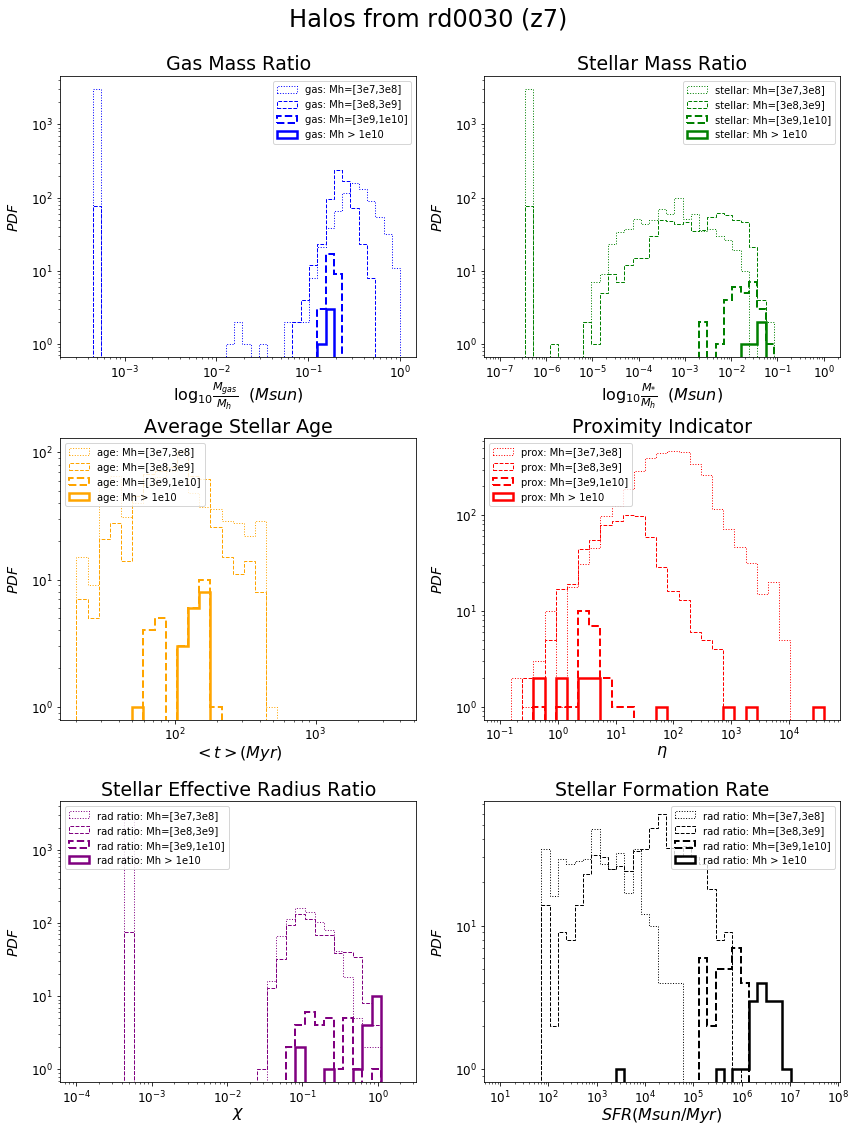

In [911]:
# create subplots
fig1 = plt.figure(figsize = (12,16))
ax1 = plt.subplot(3,2,1)
ax2 = plt.subplot(3,2,2)
ax3 = plt.subplot(3,2,3)
ax4 = plt.subplot(3,2,4)
ax5 = plt.subplot(3,2,5)
ax6 = plt.subplot(3,2,6)

# plot titles
gastitle = "Gas Mass Ratio"
stellartitle = "Stellar Mass Ratio"
agetitle = "Average Stellar Age"
proxtitle = "Proximity Indicator"
radtitle = "Stellar Effective Radius Ratio"
formtitle = "Stellar Formation Rate"

# plot various lists
ratiolists = [ratiolist1, ratiolist2]
ax1.hist(ploting['gasratio'][0], gasbins, ec = 'blue', lw = 1, label = 'gas: Mh=[3e7,3e8]', linestyle = ":", histtype='step', fill = False)
ax1.hist(ploting['gasratio'][1], gasbins, ec = 'blue', lw = 1, label = 'gas: Mh=[3e8,3e9]', linestyle = "--",histtype='step', fill = False)
ax1.hist(ploting['gasratio'][2], gasbins, ec = 'blue', lw = 2, label = 'gas: Mh=[3e9,1e10]', linestyle = "--", histtype='step', fill = False)
ax1.hist(ploting['gasratio'][3], gasbins, ec = 'blue', lw = 2.5, label = 'gas: Mh > 1e10', linestyle = "-", histtype='step', fill = False)
ax2.hist(ploting['stelratio'][0], stelbins, ec = 'green', lw = 1, label = 'stellar: Mh=[3e7,3e8]', linestyle = ":", histtype='step', fill = False)
ax2.hist(ploting['stelratio'][1], stelbins, ec = 'green', lw = 1, label = 'stellar: Mh=[3e8,3e9]', linestyle = "--",histtype='step', fill = False)
ax2.hist(ploting['stelratio'][2], stelbins, ec = 'green', lw = 2, label = 'stellar: Mh=[3e9,1e10]', linestyle = "--", histtype='step', fill = False)
ax2.hist(ploting['stelratio'][3], stelbins, ec = 'green', lw = 2.5, label = 'stellar: Mh > 1e10', linestyle = "-", histtype='step', fill = False)
ax3.hist(ploting['age'][0], agebins, ec = 'orange', lw = 1, label = 'age: Mh=[3e7,3e8]', linestyle = ":", histtype='step', fill = False)
ax3.hist(ploting['age'][1], agebins, ec = 'orange', lw = 1, label = 'age: Mh=[3e8,3e9]', linestyle = "--",histtype='step', fill = False)
ax3.hist(ploting['age'][2], agebins, ec = 'orange', lw = 2, label = 'age: Mh=[3e9,1e10]', linestyle = "--", histtype='step', fill = False)
ax3.hist(ploting['age'][3], agebins, ec = 'orange', lw = 2.5, label = 'age: Mh > 1e10', linestyle = "-", histtype='step', fill = False)
ax4.hist(ploting['prox'][0], proxbins, ec = 'red', lw = 1, label = 'prox: Mh=[3e7,3e8]', linestyle = ":", histtype='step', fill = False)
ax4.hist(ploting['prox'][1], proxbins, ec = 'red', lw = 1, label = 'prox: Mh=[3e8,3e9]', linestyle = "--",histtype='step', fill = False)
ax4.hist(ploting['prox'][2], proxbins, ec = 'red', lw = 2, label = 'prox: Mh=[3e9,1e10]', linestyle = "--", histtype='step', fill = False)
ax4.hist(ploting['prox'][3], proxbins, ec = 'red', lw = 2.5, label = 'prox: Mh > 1e10', linestyle = "-", histtype='step', fill = False)
ax5.hist(ploting['chi'][0], radbins, ec = 'purple', lw = 1, label = 'rad ratio: Mh=[3e7,3e8]', linestyle = ":", histtype='step', fill = False)
ax5.hist(ploting['chi'][1], radbins, ec = 'purple', lw = 1, label = 'rad ratio: Mh=[3e8,3e9]', linestyle = "--",histtype='step', fill = False)
ax5.hist(ploting['chi'][2], radbins, ec = 'purple', lw = 2, label = 'rad ratio: Mh=[3e9,1e10]', linestyle = "--", histtype='step', fill = False)
ax5.hist(ploting['chi'][3], radbins, ec = 'purple', lw = 2.5, label = 'rad ratio: Mh > 1e10', linestyle = "-", histtype='step', fill = False)
ax6.hist(ploting['form'][0], formbins, ec = 'black', lw = 1, label = 'rad ratio: Mh=[3e7,3e8]', linestyle = ":", histtype='step', fill = False)
ax6.hist(ploting['form'][1], formbins, ec = 'black', lw = 1, label = 'rad ratio: Mh=[3e8,3e9]', linestyle = "--",histtype='step', fill = False)
ax6.hist(ploting['form'][2], formbins, ec = 'black', lw = 2, label = 'rad ratio: Mh=[3e9,1e10]', linestyle = "--", histtype='step', fill = False)
ax6.hist(ploting['form'][3], formbins, ec = 'black', lw = 2.5, label = 'rad ratio: Mh > 1e10', linestyle = "-", histtype='step', fill = False)

# set title
plt.suptitle(figtitle, fontsize = 24)
ax1.set_title(gastitle, size = 19)
ax2.set_title(stellartitle, size = 19)
ax3.set_title(agetitle, size = 19)
ax4.set_title(proxtitle, size = 19)
ax5.set_title(radtitle, size = 19)
ax6.set_title(formtitle, size = 19)
#ax1.axis([1e-4, 10**1.5, 0, 700])

# create axis labels
gaslab = r"$\log_{10}\frac{M_{gas}}{M_h}$  $(Msun)$"
stellab = r"$\log_{10}\frac{M_{*}}{M_h}$  $(Msun)$"
agelab = r"$<t> (Myr)$"
proxlab = r"$\eta$"
radlab = r"$\chi$"
formlab = r"$SFR (Msun / Myr)$"
ylab = "$PDF$"
ax1.set_xlabel(gaslab, size = 16, labelpad= 0)
ax2.set_xlabel(stellab, size = 16, labelpad= 0)
ax3.set_xlabel(agelab, size = 16, labelpad= 0)
ax4.set_xlabel(proxlab, size = 16, labelpad= 0)
ax5.set_xlabel(radlab, size = 16, labelpad= 0)
ax6.set_xlabel(formlab, size = 16, labelpad= 0)
ax1.set_ylabel(ylab, rotation = 90, size = 14, labelpad= 10)
ax2.set_ylabel(ylab, rotation = 90, size = 14, labelpad= 10)
ax3.set_ylabel(ylab, rotation = 90, size = 14, labelpad= 10)
ax4.set_ylabel(ylab, rotation = 90, size = 14, labelpad= 10)
ax5.set_ylabel(ylab, rotation = 90, size = 14, labelpad= 10)
ax6.set_ylabel(ylab, rotation = 90, size = 14, labelpad= 10)

# create axis ticks 
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.tick_params(axis='x', which='major', labelsize=12)
ax1.tick_params(axis='y', which='major', labelsize=12)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.tick_params(axis='x', which='major', labelsize=12)
ax2.tick_params(axis='y', which='major', labelsize=12)
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.tick_params(axis='x', which='major', labelsize=12)
ax3.tick_params(axis='y', which='major', labelsize=12)
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.tick_params(axis='x', which='major', labelsize=12)
ax4.tick_params(axis='y', which='major', labelsize=12)
ax5.set_xscale('log')
ax5.set_yscale('log')
ax5.tick_params(axis='x', which='major', labelsize=12)
ax5.tick_params(axis='y', which='major', labelsize=12)
ax6.set_xscale('log')
ax6.set_yscale('log')
ax6.tick_params(axis='x', which='major', labelsize=12)
ax6.tick_params(axis='y', which='major', labelsize=12)

# add labels for each plot
# annotation1 = 'using .sum'
# annotation2 = 'using particle mask'
# ax1.text(start, 20, annotation1, size = 12)
# ax2.text(start, 30, annotation2, size = 12)

# set axis limits
# ax2.set_xlim([1e-7, 0.5])

# add legend
ax1.legend(loc = 'upper right')
ax2.legend(loc = 'upper right')
ax3.legend(loc = 'upper left')
ax4.legend(loc = 'upper left')
ax5.legend(loc = 'upper left')
ax6.legend(loc = 'upper right')

# adjust spacing and show
plt.tight_layout()
fig1.subplots_adjust(top=0.92)
plt.show()

#plt.savefig('./LG4_2048_40pc/rd0070/massratios.png', dpi = 300)

In [915]:
# create log ratios and other useful lists
stellogratio1 = np.log([value for value in ploting['stelratio'][0] if value > 0]) / log(10)
stellogratio2 = np.log([value for value in ploting['stelratio'][1] if value > 0]) / log(10)
stellogratio3 = np.log([value for value in ploting['stelratio'][2] if value > 0]) / log(10)
stellogratio4 = np.log([value for value in ploting['stelratio'][3] if value > 0]) / log(10)

age_log1 = np.log([value for value in ploting['age'][0] if value > 0]) / log(10)
age_log2 = np.log([value for value in ploting['age'][1] if value > 0]) / log(10)
age_log3 = np.log([value for value in ploting['age'][2] if value > 0]) / log(10)
age_log4 = np.log([value for value in ploting['age'][3] if value > 0]) / log(10)
plot_agelog1 = 3**(age_log1**2)/10
plot_agelog2 = 3**(age_log2**2)/10
plot_agelog3 = 3**(age_log3**2)/10
plot_agelog4 = 3**(age_log4**2)/10

ploting["stellog"] = [stellogratio1, stellogratio2, stellogratio3, stellogratio4]
ploting["ageweight"] = [plot_agelog1, plot_agelog2, plot_agelog3, plot_agelog4]

In [775]:
ploting["ageweight"][0]

array([  7.33183494,   1.39568457,  48.39077363, ...,   0.3       ,
         0.3       ,   0.3       ])

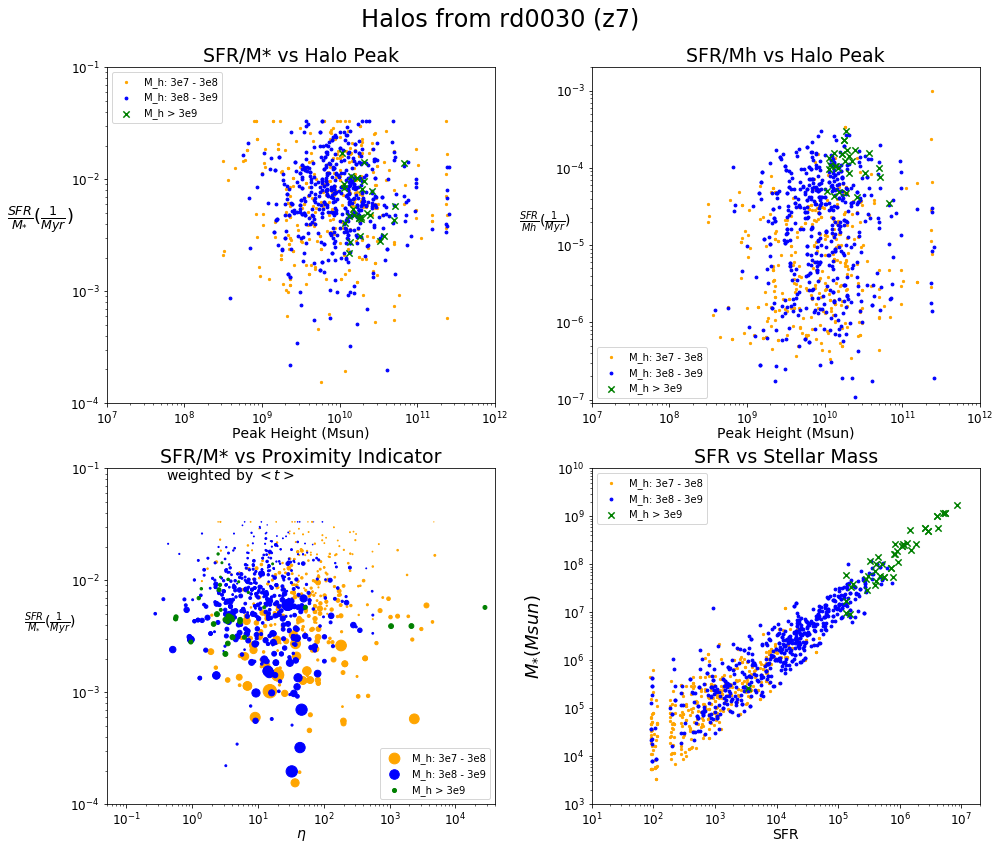

In [841]:
# specify figure size
fig2 = plt.figure(figsize=(14,12))
ax1 = fig2.add_subplot(221)
ax2 = fig2.add_subplot(222)
ax3 = fig2.add_subplot(223)
ax4 = fig2.add_subplot(224)

# create plot titles
peakformtitle = "SFR/M* vs Halo Peak"
formratiotitle = "SFR/Mh vs Halo Peak"
proxformtitle = "SFR/M* vs Proximity Indicator"
formsteltitle = "SFR vs Stellar Mass"

# set titles
plt.suptitle(figtitle, fontsize = 24)
ax1.set_title(peakformtitle, size = 19)
ax2.set_title(formratiotitle, size = 19)
ax3.set_title(proxformtitle, size = 19)
ax4.set_title(formsteltitle, size = 19)

# # --determine line of best fit
# # reduce range of values to fit line
# bin_edges_fit1 = bin_edges1[8:-10]
# bin_edges_fit2 = bin_edges2[16:-4]
# log_density_fit1 = log_density1[7:-10]
# log_density_fit2 = log_density2[15:-4]
# # determine line
# par1 = np.polyfit(bin_edges_fit1, log_density_fit1, 1, full=True)
# par2 = np.polyfit(bin_edges_fit2, log_density_fit2, 1, full=True)
# slope1, intercept1 = par1[0][0], par1[0][1]
# slope2, intercept2 = par2[0][0], par2[0][1]

# plot data 
ax1.scatter(ploting["peak"][0], ploting["formstel"][0], c = 'orange', s = 5, label = 'M_h: 3e7 - 3e8')
ax1.scatter(ploting["peak"][1], ploting["formstel"][1], c = 'blue', s = 8, label = 'M_h: 3e8 - 3e9')
ax1.scatter(ploting["peak"][2], ploting["formstel"][2], c = 'green', s = 40, label = 'M_h > 3e9', marker = 'x')

ax2.scatter(ploting["peak"][0], ploting["formratio"][0], c = 'orange', s = 5, cmap='binary', label = 'M_h: 3e7 - 3e8')
ax2.scatter(ploting["peak"][1], ploting["formratio"][1], c = 'blue', s = 8, cmap='binary', label = 'M_h: 3e8 - 3e9')
ax2.scatter(ploting["peak"][2], ploting["formratio"][2], c = 'green', s = 40, cmap='binary', label = 'M_h > 3e9', marker = 'x')

ax3.scatter(ploting["prox"][0], ploting["formstel"][0], c = 'orange', s = ploting["ageweight"][0], cmap='binary', label = 'M_h: 3e7 - 3e8')
ax3.scatter(ploting["prox"][1], ploting["formstel"][1], c = 'blue', s = ploting["ageweight"][1], cmap='binary', label = 'M_h: 3e8 - 3e9')
ax3.scatter(ploting["prox"][2], ploting["formstel"][2], c = 'green', s = ploting["ageweight"][2], cmap='binary', label = 'M_h > 3e9')

ax4.scatter(ploting["form"][0], ploting["stelmass"][0], c = 'orange', s = 5, label = 'M_h: 3e7 - 3e8')
ax4.scatter(ploting["form"][1], ploting["stelmass"][1], c = 'blue', s = 8, label = 'M_h: 3e8 - 3e9')
ax4.scatter(ploting["form"][2], ploting["stelmass"][2], c = 'green', s = 40, label = 'M_h > 3e9', marker = 'x')
# ax2.plot(bin_edges_red1, slope1 * bin_edges_red1 + intercept1, color = 'red')
# ax2.plot(bin_edges_red2, slope2 * bin_edges_red2 + intercept2, color = 'red')

# create axis labels
agelab = "$<t> (Myr)$"
proxlab = r"$\eta$"
radlab = r"$\chi$"
peaklab = "Peak Height (Msun)"
formlab = "SFR"
formratiolab = r"$\frac{SFR}{Mh} (\frac{1}{Myr})$"
formstellab = r"$\frac{SFR}{M_{*}} (\frac{1}{Myr})$"
stellab = "$M_{*}(Msun)$"
ylab = r"$log_{10}\frac{M_{*}}{M_h}$"
ax1.set_xlabel(peaklab, size = 14, labelpad= 0)
ax1.set_ylabel(formstellab, rotation = 0, size = 18, labelpad= 30)
ax2.set_xlabel(peaklab, size = 14, labelpad= 0)
ax2.set_ylabel(formratiolab, rotation = 0, size = 14, labelpad= 10)
ax3.set_xlabel(proxlab, size = 14, labelpad= 0)
ax3.set_ylabel(formstellab, rotation = 0, size = 14, labelpad= 20)
ax4.set_xlabel(formlab, size = 14, labelpad= 0)
ax4.set_ylabel(stellab, rotation = 90, size = 18, labelpad= 15)

# create axis ticks and set axis lim
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim([1e7, 1e12])
ax1.set_ylim([1e-4, 1e-1])
ax1.tick_params(axis='x', which='major', labelsize=12)
ax1.tick_params(axis='y', which='major', labelsize=12)

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim([1e7, 1e12])
ax2.set_ylim([9e-8, 2e-3])
ax2.tick_params(axis='x', which='major', labelsize=12)
ax2.tick_params(axis='y', which='major', labelsize=12)

ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlim([5e-2,4e4])
ax3.set_ylim([1e-4, 1e-1])
ax3.tick_params(axis='x', which='major', labelsize=12)
ax3.tick_params(axis='y', which='major', labelsize=12)

ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_xlim([1e1, 2e7])
ax4.set_ylim([1e3, 1e10])
ax4.tick_params(axis='x', which='major', labelsize=12)
ax4.tick_params(axis='y', which='major', labelsize=12)

# add annotation
annotation = r"weighted by $<t>$"
ax3.text(4e-1, 8e-2, annotation, size = 14)

# add legend
ax1.legend(loc = 'upper left')
ax2.legend(loc = 'lower left')
ax3.legend(loc = 'lower right')
ax4.legend(loc = 'upper left')

# adjust spacing and show
plt.tight_layout()
fig2.subplots_adjust(top=0.91)
plt.show()

# 7-12, 26-27, 24-32, 45-53

In [943]:
# create copies of master lists
plot0030 = lists0030
plot0050 = lists0050
plot0070 = lists0070
plot0090 = lists0090
plot0110 = lists0110
mass1 = 3e7 / 1.15


for tempdict in (plot0030, plot0050, plot0070, plot0090, plot0110):
    # find time now and omegas
    time_now, omegalist = findOmegas(tempdict["paramfile"])
    omega_m, omega_b = omegalist[0], omegalist[1]
    
    # find mass bins
    mass1 = 1.15*mass1
    mass2 = mass1*10
    mass3 = mass2*10
    mass4 = mass3*10
    
    # convert lists to np arrays and sort
    stelsorted1 = np.sort(tempdict['stelratio'][0])
    stelsorted2 = np.sort(tempdict['stelratio'][1])
    stelsorted3 = np.sort(tempdict['stelratio'][2])
    stelsorted4 = np.sort(tempdict['stelratio'][3])
    agelog1 = np.sort(np.log(tempdict['age'][0]) / log(10))
    agelog2 = np.sort(np.log(tempdict['age'][1]) / log(10))
    agelog3 = np.sort(np.log(tempdict['age'][2]) / log(10))
    agelog4 = np.sort(np.log(tempdict['age'][3]) / log(10))
    formstelsorted1 = np.sort(tempdict['formstel'][0])
    formstelsorted2 = np.sort(tempdict['formstel'][1])
    formstelsorted3 = np.sort(tempdict['formstel'][2])
    formstelsorted4 = np.sort(tempdict['formstel'][3])
    formratiosorted1 = np.sort(tempdict['formratio'][0])
    formratiosorted2 = np.sort(tempdict['formratio'][1])
    formratiosorted3 = np.sort(tempdict['formratio'][2])
    formratiosorted4 = np.sort(tempdict['formratio'][3])
    
    # filter out unnecessary results
    stelsorted1 = stelsorted1[stelsorted1 > 1e-6] * (omega_m / omega_b)
    stelsorted2 = stelsorted2[stelsorted2 > 1e-6] * (omega_m / omega_b)
    stelsorted3 = stelsorted3[stelsorted3 > 1e-6] * (omega_m / omega_b)
    stelsorted4 = stelsorted4[stelsorted4 > 1e-6] * (omega_m / omega_b)
    agelog1 = agelog1[0 < agelog1] / time_now
    agelog2 = agelog2[0 < agelog2] / time_now
    agelog3 = agelog3[0 < agelog3] / time_now
    agelog4 = agelog4[0 < agelog4] / time_now
    formstelsorted1 = formstelsorted1[0 < formstelsorted1] * time_now
    formstelsorted2 = formstelsorted2[0 < formstelsorted2] * time_now
    formstelsorted3 = formstelsorted3[0 < formstelsorted3] * time_now
    formstelsorted4 = formstelsorted4[0 < formstelsorted4] * time_now
    formratiosorted1 = formratiosorted1[0 < formratiosorted1] * time_now
    formratiosorted2 = formratiosorted2[0 < formratiosorted2] * time_now
    formratiosorted3 = formratiosorted3[1e-41 < formratiosorted3] * time_now
    formratiosorted4 = formratiosorted4[1e-19 < formratiosorted4] * time_now
    
    print(formratiosorted4)
    
    # find median, and 25%, 75% 
    stelmed1, stellow1, stelhigh1 = find_distribution(stelsorted1)
    stelmed2, stellow2, stelhigh2 = find_distribution(stelsorted2)
    stelmed3, stellow3, stelhigh3 = find_distribution(stelsorted3)
    stelmed4, stellow4, stelhigh4 = find_distribution(stelsorted4)
    
    agemed1, agelow1, agehigh1 = find_distribution(agelog1)
    agemed2, agelow2, agehigh2 = find_distribution(agelog2)
    agemed3, agelow3, agehigh3 = find_distribution(agelog3)
    agemed4, agelow4, agehigh4 = find_distribution(agelog4)
    
    formstelmed1, formstellow1, formstelhigh1 = find_distribution(formstelsorted1)
    formstelmed2, formstellow2, formstelhigh2 = find_distribution(formstelsorted2)
    formstelmed3, formstellow3, formstelhigh3 = find_distribution(formstelsorted3)
    formstelmed4, formstellow4, formstelhigh4 = find_distribution(formstelsorted4)
    
    formratiomed1, formratiolow1, formratiohigh1 = find_distribution(formratiosorted1)
    formratiomed2, formratiolow2, formratiohigh2 = find_distribution(formratiosorted2)
    formratiomed3, formratiolow3, formratiohigh3 = find_distribution(formratiosorted3)
    formratiomed4, formratiolow4, formratiohigh4 = find_distribution(formratiosorted4)

    print(formratiomed4, formratiolow4, formratiohigh4)
    
    # add to dict
    tempdict["stelmeds"] = [stelmed1, stelmed2, stelmed3, stelmed4]
    tempdict["stellows"] = [stellow1, stellow2, stellow3, stellow4]
    tempdict["stelhighs"] = [stelhigh1, stelhigh2, stelhigh3, stelhigh4]
    
    tempdict["agemeds"] = [agemed1, agemed2, agemed3, agemed4]
    tempdict["agelows"] = [agelow1, agelow2, agelow3, agelow4]
    tempdict["agehighs"] = [agehigh1, agehigh2, agehigh3, agehigh4]
    
    tempdict["formstelmeds"] = [formstelmed1, formstelmed2, formstelmed3, formstelmed4]
    tempdict["formstellows"] = [formstellow1, formstellow2, formstellow3, formstellow4]
    tempdict["formstelhighs"] = [formstelhigh1, formstelhigh2, formstelhigh3, formstelhigh4]
    
    tempdict["formratiomeds"] = [formratiomed1, formratiomed2, formratiomed3, formratiomed4]
    tempdict["formratiolows"] = [formratiolow1, formratiolow2, formratiolow3, formratiolow4]
    tempdict["formratiohighs"] = [formratiohigh1, formratiohigh2, formratiohigh3, formratiohigh4]
    tempdict["massbins"] = [mass1, mass2, mass3, mass4]

/home/ygovil/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater
/home/ygovil/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in greater


[ 0.0665986   0.07764513  0.17657132  0.17657132]
0.127108224469 0.0494630992622 0.0494630992622
[ 0.03319613  0.0669609   0.12288037  0.15340016  0.16790309  0.16790309
  0.18691423  0.1960527   0.20556933]
0.167903092432 0.0450227240745 0.0190111337434
[ 0.04666868  0.06989697  0.08323814  0.09689029  0.09689923  0.12116314
  0.12117575  0.12625951  0.13039415  0.13073774  0.138158    0.1412893
  0.14753271  0.1485291   0.15065795  0.15918154  0.16530033  0.16696316
  0.18052734  0.18300388  0.19010888  0.20498905  0.20645957  0.22471959
  0.22481343  0.22759949  0.23728958  0.24662412  0.24876713  0.26060496
  0.3673723   0.3925445 ]
0.162240938545 0.0318467932115 0.0625724886051
[ 0.04886586  0.06160324  0.08210525  0.08858482  0.0973078   0.10348277
  0.10794249  0.10980684  0.10993533  0.1106429   0.11405604  0.11460515
  0.11564272  0.11581753  0.11974019  0.12138535  0.12162139  0.12272401
  0.12557933  0.12858009  0.12932733  0.13281174  0.13708617  0.14002616
  0.14118083  0.

/home/ygovil/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in greater


[ 0.00808879  0.03526044  0.03691066  0.05317447  0.05770978  0.06121928
  0.06282207  0.07111923  0.07112452  0.07210055  0.07601505  0.07813498
  0.08177046  0.08182101  0.08390524  0.0846597   0.08534858  0.08614468
  0.08707263  0.08776504  0.09288133  0.09435946  0.09475173  0.09523846
  0.09769293  0.10221406  0.10388068  0.10447684  0.10507199  0.10512647
  0.10612886  0.10849176  0.11076156  0.11080307  0.11295905  0.11955284
  0.11993675  0.12253513  0.12307068  0.12435849  0.12785087  0.13168624
  0.13778037  0.13894601  0.14133546  0.14167487  0.14330334  0.14491401
  0.14889441  0.15034901  0.15040477  0.15117352  0.15263558  0.15521242
  0.15975993  0.16188108  0.16657472  0.1667998   0.16818573  0.16848192
  0.16935435  0.16941376  0.17045418  0.17784364  0.18020983  0.18073137
  0.18086408  0.18148066  0.19159913  0.19326646  0.1943384   0.19591325
  0.19716753  0.20024169  0.20446525  0.20733862  0.21840339  0.22128811
  0.22678268  0.23306594  0.23612642  0.26320612  0

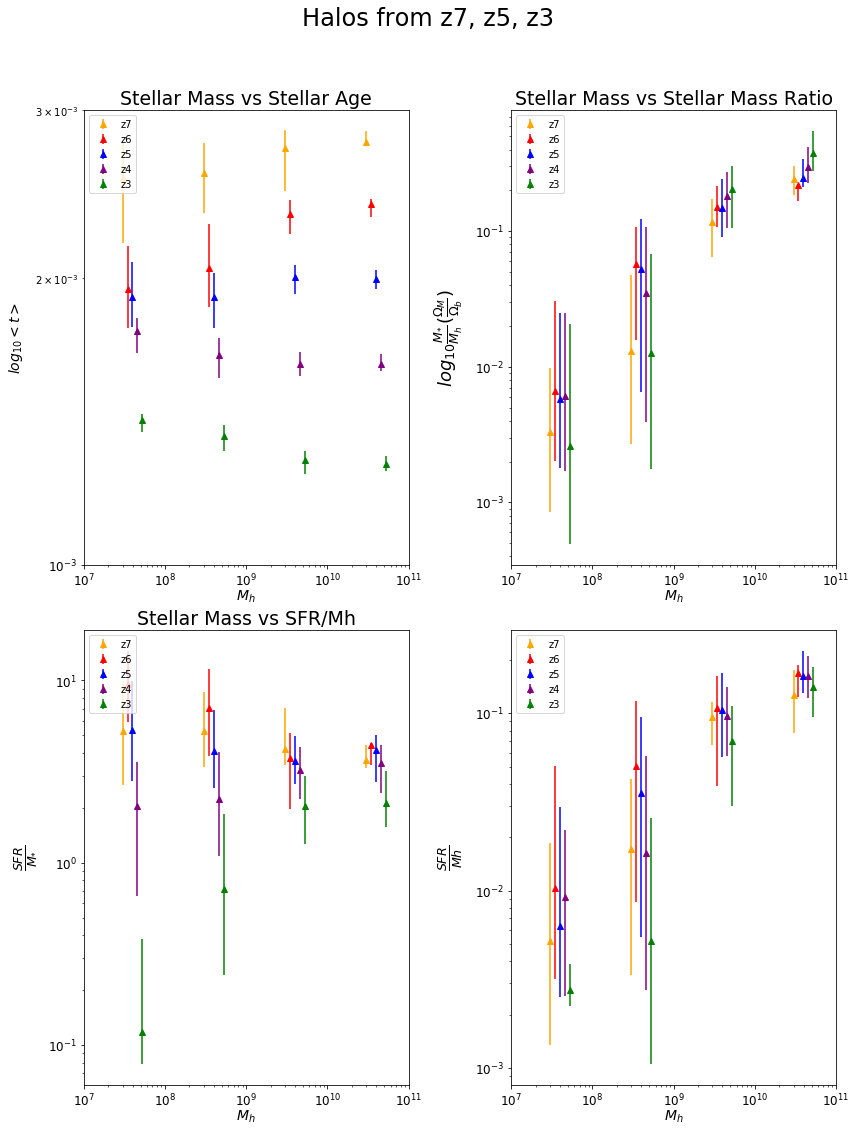

In [944]:
# specify figure size
fig3 = plt.figure(figsize=(12,16))
ax1 = fig3.add_subplot(221)
ax2 = fig3.add_subplot(222)
ax3 = fig3.add_subplot(223)
ax4 = fig3.add_subplot(224)

# create plot titles
figtitle2 = "Halos from z7, z5, z3"
agetitle = "Stellar Mass vs Stellar Age"
massratiotitle = "Stellar Mass vs Stellar Mass Ratio"
formsteltitle = "Stellar Mass vs SFR/M*"
formratiotitle = "Stellar Mass vs SFR/Mh"

# set plot titles
plt.suptitle(figtitle2, fontsize = 24)
ax1.set_title(agetitle, size = 19)
ax2.set_title(massratiotitle, size = 19)
ax3.set_title(formsteltitle, size = 19)
ax3.set_title(formratiotitle, size = 19)

# create plots
ax1.errorbar(plot0030['massbins'], plot0030['agemeds'], yerr = [plot0030['agelows'], plot0030['agehighs']],
             c = 'orange', marker="^", linestyle='None', label = 'z7')
ax1.errorbar(plot0050['massbins'], plot0050['agemeds'], yerr = [plot0050['agelows'], plot0050['agehighs']],
             c = 'red', marker="^", linestyle='None', label = 'z6')
ax1.errorbar(plot0070['massbins'], plot0070['agemeds'], yerr = [plot0070['agelows'], plot0070['agehighs']],
             c = 'blue', marker="^", linestyle='None', label = 'z5')
ax1.errorbar(plot0090['massbins'], plot0090['agemeds'], yerr = [plot0090['agelows'], plot0090['agehighs']],
             c = 'purple', marker="^", linestyle='None', label = 'z4')
ax1.errorbar(plot0110['massbins'], plot0110['agemeds'], yerr = [plot0110['agelows'], plot0110['agehighs']],
             c = 'green', marker="^", linestyle='None', label = 'z3')

ax2.errorbar(plot0030['massbins'], plot0030['stelmeds'], yerr = [plot0030['stellows'], plot0030['stelhighs']],
             c = 'orange', marker="^", linestyle='None', label = 'z7')
ax2.errorbar(plot0050['massbins'], plot0050['stelmeds'], yerr = [plot0050['stellows'], plot0050['stelhighs']],
             c = 'red', marker="^", linestyle='None', label = 'z6')
ax2.errorbar(plot0070['massbins'], plot0070['stelmeds'], yerr = [plot0070['stellows'], plot0070['stelhighs']],
             c = 'blue', marker="^", linestyle='None', label = 'z5')
ax2.errorbar(plot0090['massbins'], plot0090['stelmeds'], yerr = [plot0090['stellows'], plot0090['stelhighs']],
             c = 'purple', marker="^", linestyle='None', label = 'z4')
ax2.errorbar(plot0110['massbins'], plot0110['stelmeds'], yerr = [plot0110['stellows'], plot0110['stelhighs']],
             c = 'green', marker="^", linestyle='None', label = 'z3')

ax3.errorbar(plot0030['massbins'], plot0030['formstelmeds'], yerr = [plot0030['formstellows'], plot0030['formstelhighs']],
             c = 'orange', marker="^", linestyle='None', label = 'z7')
ax3.errorbar(plot0050['massbins'], plot0050['formstelmeds'], yerr = [plot0050['formstellows'], plot0050['formstelhighs']],
             c = 'red', marker="^", linestyle='None', label = 'z6')
ax3.errorbar(plot0070['massbins'], plot0070['formstelmeds'], yerr = [plot0070['formstellows'], plot0070['formstelhighs']],
             c = 'blue', marker="^", linestyle='None', label = 'z5')
ax3.errorbar(plot0090['massbins'], plot0090['formstelmeds'], yerr = [plot0090['formstellows'], plot0090['formstelhighs']],
             c = 'purple', marker="^", linestyle='None', label = 'z4')
ax3.errorbar(plot0110['massbins'], plot0110['formstelmeds'], yerr = [plot0110['formstellows'], plot0110['formstelhighs']],
             c = 'green', marker="^", linestyle='None', label = 'z3')

ax4.errorbar(plot0030['massbins'], plot0030['formratiomeds'], yerr = [plot0030['formratiolows'], plot0030['formratiohighs']],
             c = 'orange', marker="^", linestyle='None', label = 'z7')
ax4.errorbar(plot0050['massbins'], plot0050['formratiomeds'], yerr = [plot0050['formratiolows'], plot0050['formratiohighs']],
             c = 'red', marker="^", linestyle='None', label = 'z6')
ax4.errorbar(plot0070['massbins'], plot0070['formratiomeds'], yerr = [plot0070['formratiolows'], plot0070['formratiohighs']],
             c = 'blue', marker="^", linestyle='None', label = 'z5')
ax4.errorbar(plot0090['massbins'], plot0090['formratiomeds'], yerr = [plot0090['formratiolows'], plot0090['formratiohighs']],
             c = 'purple', marker="^", linestyle='None', label = 'z4')
ax4.errorbar(plot0110['massbins'], plot0110['formratiomeds'], yerr = [plot0110['formratiolows'], plot0110['formratiohighs']],
             c = 'green', marker="^", linestyle='None', label = 'z3')

# create axis labels
agelab = r"$log_{10}<t>$"
ratiolab = r"$log_{10}\frac{M_{*}}{M_h} (\frac{\Omega_M}{\Omega_b})$"
formratiolab = r"$\frac{SFR}{Mh}$"
formstellab = r"$\frac{SFR}{M_{*}}$"
masslab = r"$M_h$"
ax1.set_xlabel(masslab, size = 14, labelpad= 0)
ax1.set_ylabel(agelab, rotation = 90, size = 14, labelpad= 10)
ax2.set_xlabel(masslab, size = 14, labelpad= 0)
ax2.set_ylabel(ratiolab, rotation = 90, size = 18, labelpad= 10)
ax3.set_xlabel(masslab, size = 14, labelpad= 0)
ax3.set_ylabel(formstellab, rotation = 90, size = 18, labelpad= 10)
ax4.set_xlabel(masslab, size = 14, labelpad= 0)
ax4.set_ylabel(formratiolab, rotation = 90, size = 18, labelpad= 10)

# create axis ticks 
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.tick_params(axis='x', which='major', labelsize=12)
ax1.tick_params(axis='y', which='major', labelsize=12)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.tick_params(axis='x', which='major', labelsize=12)
ax2.tick_params(axis='y', which='major', labelsize=12)
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.tick_params(axis='x', which='major', labelsize=12)
ax3.tick_params(axis='y', which='major', labelsize=12)
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.tick_params(axis='x', which='major', labelsize=12)
ax4.tick_params(axis='y', which='major', labelsize=12)

# set axis limits
ax1.set_xlim([1e7, 1e11])
ax1.set_ylim([1e-3, 3e-3])
ax2.set_xlim([1e7, 1e11])
# ax2.set_ylim([-4.2, -1])
ax3.set_xlim([1e7, 1e11])
# ax3.set_ylim([1e-5, 1e-1])
ax4.set_xlim([1e7, 1e11])
# ax4.set_ylim([1e-7, 6e-4])

# add legend
ax1.legend(loc = 'upper left')
ax2.legend(loc = 'upper left')
ax3.legend(loc = 'upper left')
ax4.legend(loc = 'upper left')

# adjust spacing and show
plt.tight_layout()
fig3.subplots_adjust(top=0.89)
plt.show()

In [861]:
# create function that returns omegas and time now
def findOmegas(filename):
    # load redshift and Omega values from parameter file
    with open(filename, 'rt') as param_file:
        param_contents = param_file.read()

        #redshift
        cindex1 = param_contents.find('CosmologyCurrentRedshift')
        cindex_eq = param_contents.find('=', cindex1)
        cindex2 = param_contents.find('\n', cindex_eq, cindex_eq + 100)
        redshift = float(param_contents[cindex_eq+2:cindex2])

        # omega_m
        cindex1 = param_contents.find('CosmologyOmegaMatterNow')
        cindex_eq = param_contents.find('=', cindex1)
        cindex2 = param_contents.find('\n', cindex_eq, cindex_eq + 100)
        omega_m = float(param_contents[cindex_eq+2:cindex2])

        # hubble const now
        cindex1 = param_contents.find('CosmologyHubbleConstantNow')
        cindex_eq = param_contents.find('=', cindex1)
        cindex2 = param_contents.find('\n', cindex_eq, cindex_eq + 100)
        hubb_now = float(param_contents[cindex_eq+2:cindex2]) *(u.km / u.s / u.Mpc) 

        # cosmological constant
        cindex1 = param_contents.find('CosmologyOmegaLambdaNow')
        cindex_eq = param_contents.find('=', cindex1)
        cindex2 = param_contents.find('\n', cindex_eq, cindex_eq + 100)
        cos_const = float(param_contents[cindex_eq+2:cindex2])

        # omega baryon as specified by Renyue
        omega_b = 0.048

        # box size
        cindex1 = param_contents.find('CosmologyComovingBoxSize')
        cindex_eq = param_contents.find('=', cindex1)
        cindex2 = param_contents.find('\n', cindex_eq, cindex_eq + 100)
        box_size = float(param_contents[cindex_eq+2:cindex2]) * u.Mpc

        # left edge strings
        cindex1 = param_contents.find('RefineRegionLeftEdge')
        cindex_eq = param_contents.find('=', cindex1)
        cindex2 = param_contents.find('\n', cindex_eq, cindex_eq + 100)
        left_edge_string = param_contents[cindex_eq+2:cindex2]
        left_edges = left_edge_string.split()

        # right edge strings
        cindex1 = param_contents.find('RefineRegionRightEdge')
        cindex_eq = param_contents.find('=', cindex1)
        cindex2 = param_contents.find('\n', cindex_eq, cindex_eq + 100)
        right_edge_string = param_contents[cindex_eq+2:cindex2]
        right_edges = right_edge_string.split()

    # calculate hubble const for simulation
    hubb_z = (100* hubb_now.to('s**-1')) * ((omega_m * (1 + redshift)**3) + (1 - omega_m))**0.5

    # calculate crit density and threshold
    GRAV_CONST = (6.67408e-11 * u.m**3 /(u.kg * u.s**2)).to('cm^3*g^-1*s^-2')
    crit_dens = (3 * hubb_z**2) / (8 * pi * GRAV_CONST)
    omegas = (1 - (omega_b / omega_m))
    threshold = 200 * omegas * crit_dens

    # calculate current time
    co = Cosmology(hubb_now.value, omega_m, cos_const)
    time_now = co.hubble_time(redshift) * u.s

    # return time now and omegas
    return time_now.to('Myr').value, [omega_m, omega_b]

# create funciton to find median, lower and upper bounds
def find_distribution(inlist):
    median = np.median(inlist)
    low = inlist[int(len(inlist)/4)]
    low = median - low
    high = inlist[int(3*len(inlist)/4)]
    high = high - median
    return median, low, high

In [124]:
# find log arrays for ratio lists
log_ratio1 = np.log(ratiolist1) / log(10)
log_ratio2 = np.log([value for value in ratiolist2 if value > 0]) / log(10)

# find histogram parameters
density1, bin_edges1 = np.histogram(log_ratio1, bins= np.linspace(-3.5, 0.4, 39))
density2, bin_edges2 = np.histogram(log_ratio2, bins= np.linspace(-2.2, 1.1, 33))


log_density1 = np.log(density1) / log(10)
log_density2 = np.log(density2) / log(10)

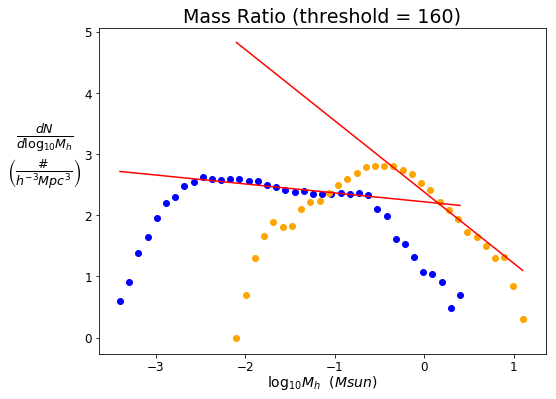

In [161]:
# specify figure size
fig2 = plt.figure(figsize=(8,6))
ax2 = fig2.add_subplot(111)

# --determine line of best fit
# reduce range of values to fit line
bin_edges_fit1 = bin_edges1[8:-10]
bin_edges_fit2 = bin_edges2[16:-4]
log_density_fit1 = log_density1[7:-10]
log_density_fit2 = log_density2[15:-4]
# determine line
par1 = np.polyfit(bin_edges_fit1, log_density_fit1, 1, full=True)
par2 = np.polyfit(bin_edges_fit2, log_density_fit2, 1, full=True)
slope1, intercept1 = par1[0][0], par1[0][1]
slope2, intercept2 = par2[0][0], par2[0][1]

# plot data and line
bin_edges_red1 = bin_edges1[1:]
bin_edges_red2 = bin_edges2[1:]
ax2.scatter(bin_edges_red1, log_density1, color = 'blue')
ax2.scatter(bin_edges_red2, log_density2, color = 'orange')
ax2.plot(bin_edges_red1, slope1 * bin_edges_red1 + intercept1, color = 'red')
ax2.plot(bin_edges_red2, slope2 * bin_edges_red2 + intercept2, color = 'red')
ax2.set_title("Mass Ratio (threshold = 160)", size = 19)

# create axis labels
xlab = "$\log_{10}M_h}$  $(Msun)$"
ylab = r"$\frac{dN}{d\log_{10}M_h}$"+"\n"+r"$\left(\frac{\#}{h^{-3}Mpc^3}\right)$"
ax2.set_xlabel(xlab, size = 14, labelpad= 0)
ax2.set_ylabel(ylab, rotation = 0, size = 18, labelpad= 40)

# create axis ticks 
ax2.set_yscale('linear')
ax2.tick_params(axis='x', which='major', labelsize=12)
ax2.tick_params(axis='y', which='major', labelsize=12)

# add slope and intercept
# annotation = "$a = {:1.3f}$ \n$b = {:1.3f}$".format(slope, intercept)
# plt.text(9.5, 1.5, annotation, size = 12)

#show and save
plt.show()

In [706]:
count=0
for halo in halo_list0110:
    halo_mass = halo[5] # new mass
    
    if halo_mass > 3e10 * u.Msun:
        count +=1

print(count)

143
